In [1]:
import gymnasium as gym
import pandas as pd
import numpy as np
import pandas_ta as ta
import gym_trading_env
import math
import random
import datetime
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from gym_trading_env.downloader import download
from itertools import count
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Constants
DIR = "../../data"
SYMBOL = "ADA/USDT" # you can change to any other symbol
TIMEFRAME = "1h" # 5m 15m 1h 4h 1d 1w 1M
EXCHANGE = "binance" # bitget binance bitfinex bitmex bitstamp coinbasepro huobi kraken kucoin okex
DISCORD_WEBHOOK_URL = ""

In [3]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
download(exchange_names = [EXCHANGE],
    symbols= [SYMBOL],
    timeframe= TIMEFRAME,
    dir = DIR,
    since= datetime.datetime(year= 2023, month= 10, day= 10),
)
# Import your fresh data
df = pd.read_pickle(DIR+"/"+EXCHANGE+"-"+SYMBOL.replace("/","")+"-"+TIMEFRAME+".pkl")

ADA/USDT downloaded from binance and stored at ../../data/binance-ADAUSDT-1h.pkl


In [4]:
# Handle more feature
df['feature_open'] = df['open']
df['feature_high'] = df['high']
df['feature_low'] = df['low']
df['feature_close'] = df['close']
df['feature_volume'] = df['volume']
df['feature_close_pct_change'] = df['close'].pct_change()
df['feature_volume_pct_change'] = df['volume'].pct_change()
df['feature_shift_1_close'] = df['close'].shift(1)
df['feature_shift_1_volume'] = df['volume'].shift(1)
df['feature_shift_1_close_pct_change'] = df['close'].shift(1)
df['feature_shift_1_volume_pct_change'] = df['volume'].shift(1)
df['feature_shift_2_close'] = df['close'].shift(2)
df['feature_shift_2_volume'] = df['volume'].shift(2)
df['feature_shift_3_close'] = df['close'].shift(3)
df['feature_shift_3_volume'] = df['volume'].shift(3)
df['feature_shift_4_close'] = df['close'].shift(4)
df['feature_shift_4_volume'] = df['volume'].shift(4)
df['feature_shift_5_close'] = df['close'].shift(5)
df['feature_shift_5_volume'] = df['volume'].shift(5)
df['feature_LONGLINE'] = df.ta.cdl_pattern(name="longline")['CDL_LONGLINE']
temp = df.ta.macd()
df['feature_MACD'] = temp['MACD_12_26_9']   
df['feature_MACD_SIGNAL'] = temp['MACDs_12_26_9']
df['feature_MACD_HIST'] = temp['MACDh_12_26_9']
df['feature_ATR'] = df.ta.atr()
df['feature_ADX'] = df.ta.adx()['ADX_14']
df = df.drop(columns=['date_close'])
df = df.dropna()

In [5]:
def reward_func(history):
    # history is a list of actions
    # return a reward value
    reward_score = np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2])
    if reward_score > 0:reward_score += reward_score * 0.5
    else:reward_score -= reward_score * 0.1
    return reward_score

In [6]:
# need to switch to custom env
env = gym.make("TradingEnv", df = df, positions = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8], initial_position= 0, trading_fees = 0.02/100, reward_function = reward_func)

env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Lenght', lambda history : len(history['position']) )
env.unwrapped.add_metric('Win Rate', lambda history : np.sum(history['reward'] > 0) / len(history['reward']) )

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class BLOCK(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(BLOCK, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = F.tanh(self.layer3(x))
        return self.layer4(x)

class DQN(nn.Module): # you can customize this to your liking

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.block1 = BLOCK(n_observations, n_actions)
        self.block2 = BLOCK(n_observations, n_actions)
        self.block3 = BLOCK(n_observations, n_actions)
        self.block4 = BLOCK(n_observations, n_actions)
        self.fusion = nn.Linear(4*n_actions, n_actions)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x)
        x3 = self.block3(x)
        x4 = self.block4(x)
        x = torch.cat((x1,x2,x3,x4), dim=1)
        return F.softmax(self.fusion(x), dim=1)

In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
# MEM_SIZE is the capacity of the replay buffer
BATCH_SIZE = 1024 # change to 1024, original is 128
GAMMA = 0.9 # change to 0.9, original is 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
MEM_SIZE = 300000

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEM_SIZE)


steps_done = 0
ml_cnt = 0


def select_action(state):
    global steps_done
    global ml_cnt
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            if ml_cnt <= 2: ml_cnt += 1;print(f"Do ML, when steps_done = {steps_done}")
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Return %')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    if show_result:
        plt.savefig('result.png')
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete !
Training took 0.9040527621905009 minutes


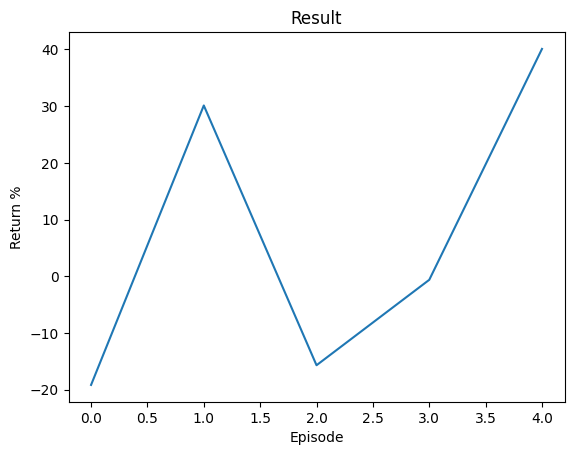

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 5

start_time = time()

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            Portfolio_Return:str = env.unwrapped.get_metrics()['Portfolio Return']
            episode_durations.append(float(Portfolio_Return.replace("%","")))
            plot_durations()
            break

end_time = time()
print('Complete !')
print(f'Training took {(end_time - start_time)/60} minutes')
plot_durations(show_result=True)

plt.ioff()
plt.show()

In [12]:
# At the end of the episode you want to render
# env.save_for_render(dir = "render_logs")

In [13]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

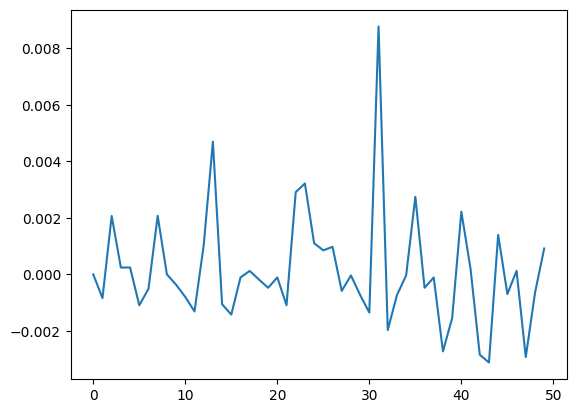

In [14]:
reward_history = env.unwrapped.historical_info['reward']
plt.plot(reward_history[:50])
plt.show()

In [15]:
import requests

# Text result

template = """
====================
Training Complete
====================

Portfolio Return: {return_value} %
Training Time: {time} minutes
"""

mertics_metadata:dict = env.unwrapped.get_metrics()
mertics_metadata.pop('Portfolio Return')
mertics_data = [f"{key}: {value}" for key, value in mertics_metadata.items()]

template += "\n".join(mertics_data)

data = {
    "content": template.format(
        return_value = Portfolio_Return.replace("%",""),
        time = (end_time - start_time)/60
    ),
    "username": "ML Training Notification",
    "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
}

r = requests.post(DISCORD_WEBHOOK_URL, data=data)

if r.status_code != 204:
    print(f"Discord Webhook returned status code {r.status_code}")
else:
    print("Discord Webhook Sent")

MissingSchema: Invalid URL '': No scheme supplied. Perhaps you meant https://?

In [ ]:
# image result

files = {
    "file": ("result.png", open("result.png", "rb"))
}

template = """
====================
Result Image
====================
"""

data = {
    "content": template,
    "username": "ML Training Notification",
    "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
}

r = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)

if r.status_code != 200:
    print(f"Discord Webhook returned status code {r.status_code}")
else:
    print("Discord Webhook Sent")